In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = "0:1"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 87612 images
Dataset type val label type: species


Loaded 21905 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 41868 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 55824 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1 v4eosct0


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-v4eosct0:best, 58.47MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:9.7


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                         | 0/685 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                | 1/685 [00:01<12:10,  1.07s/it]

  1%|█▎                                                                                                                                               | 6/685 [00:01<01:42,  6.62it/s]

  2%|██▎                                                                                                                                             | 11/685 [00:01<00:53, 12.57it/s]

  2%|███▎                                                                                                                                            | 16/685 [00:01<00:36, 18.40it/s]

  3%|████▍                                                                                                                                           | 21/685 [00:01<00:27, 23.79it/s]

  4%|█████▍                                                                                                                                          | 26/685 [00:01<00:23, 28.51it/s]

  5%|██████▌                                                                                                                                         | 31/685 [00:01<00:20, 32.39it/s]

  5%|███████▌                                                                                                                                        | 36/685 [00:01<00:18, 35.48it/s]

  6%|████████▌                                                                                                                                       | 41/685 [00:01<00:16, 37.91it/s]

  7%|█████████▋                                                                                                                                      | 46/685 [00:02<00:16, 39.67it/s]

  7%|██████████▋                                                                                                                                     | 51/685 [00:02<00:15, 40.97it/s]

  8%|███████████▊                                                                                                                                    | 56/685 [00:02<00:15, 41.92it/s]

  9%|████████████▊                                                                                                                                   | 61/685 [00:02<00:14, 42.65it/s]

 10%|█████████████▊                                                                                                                                  | 66/685 [00:02<00:14, 43.12it/s]

 10%|██████████████▉                                                                                                                                 | 71/685 [00:02<00:14, 43.42it/s]

 11%|███████████████▉                                                                                                                                | 76/685 [00:02<00:13, 43.71it/s]

 12%|█████████████████                                                                                                                               | 81/685 [00:02<00:13, 43.86it/s]

 13%|██████████████████                                                                                                                              | 86/685 [00:02<00:13, 43.96it/s]

 13%|███████████████████▏                                                                                                                            | 91/685 [00:03<00:13, 44.05it/s]

 14%|████████████████████▏                                                                                                                           | 96/685 [00:03<00:13, 44.16it/s]

 15%|█████████████████████                                                                                                                          | 101/685 [00:03<00:13, 44.19it/s]

 15%|██████████████████████▏                                                                                                                        | 106/685 [00:03<00:13, 44.21it/s]

 16%|███████████████████████▏                                                                                                                       | 111/685 [00:03<00:12, 44.28it/s]

 17%|████████████████████████▏                                                                                                                      | 116/685 [00:03<00:12, 44.25it/s]

 18%|█████████████████████████▎                                                                                                                     | 121/685 [00:03<00:12, 44.25it/s]

 18%|██████████████████████████▎                                                                                                                    | 126/685 [00:03<00:12, 44.26it/s]

 19%|███████████████████████████▎                                                                                                                   | 131/685 [00:04<00:12, 44.31it/s]

 20%|████████████████████████████▍                                                                                                                  | 136/685 [00:04<00:12, 44.29it/s]

 21%|█████████████████████████████▍                                                                                                                 | 141/685 [00:04<00:12, 44.26it/s]

 21%|██████████████████████████████▍                                                                                                                | 146/685 [00:04<00:12, 44.33it/s]

 22%|███████████████████████████████▌                                                                                                               | 151/685 [00:04<00:12, 44.31it/s]

 23%|████████████████████████████████▌                                                                                                              | 156/685 [00:04<00:11, 44.26it/s]

 24%|█████████████████████████████████▌                                                                                                             | 161/685 [00:04<00:11, 44.26it/s]

 24%|██████████████████████████████████▋                                                                                                            | 166/685 [00:04<00:11, 44.32it/s]

 25%|███████████████████████████████████▋                                                                                                           | 171/685 [00:04<00:11, 44.29it/s]

 26%|████████████████████████████████████▋                                                                                                          | 176/685 [00:05<00:11, 44.27it/s]

 26%|█████████████████████████████████████▊                                                                                                         | 181/685 [00:05<00:11, 44.35it/s]

 27%|██████████████████████████████████████▊                                                                                                        | 186/685 [00:05<00:11, 44.32it/s]

 28%|███████████████████████████████████████▊                                                                                                       | 191/685 [00:05<00:11, 44.30it/s]

 29%|████████████████████████████████████████▉                                                                                                      | 196/685 [00:05<00:11, 44.27it/s]

 29%|█████████████████████████████████████████▉                                                                                                     | 201/685 [00:05<00:10, 44.32it/s]

 30%|███████████████████████████████████████████                                                                                                    | 206/685 [00:05<00:10, 44.30it/s]

 31%|████████████████████████████████████████████                                                                                                   | 211/685 [00:05<00:10, 44.20it/s]

 32%|█████████████████████████████████████████████                                                                                                  | 216/685 [00:05<00:10, 44.29it/s]

 32%|██████████████████████████████████████████████▏                                                                                                | 221/685 [00:06<00:10, 44.26it/s]

 33%|███████████████████████████████████████████████▏                                                                                               | 226/685 [00:06<00:10, 44.25it/s]

 34%|████████████████████████████████████████████████▏                                                                                              | 231/685 [00:06<00:10, 44.25it/s]

 34%|█████████████████████████████████████████████████▎                                                                                             | 236/685 [00:06<00:10, 44.31it/s]

 35%|██████████████████████████████████████████████████▎                                                                                            | 241/685 [00:06<00:10, 44.29it/s]

 36%|███████████████████████████████████████████████████▎                                                                                           | 246/685 [00:06<00:09, 44.29it/s]

 37%|████████████████████████████████████████████████████▍                                                                                          | 251/685 [00:06<00:09, 44.26it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                         | 256/685 [00:06<00:09, 44.26it/s]

 38%|██████████████████████████████████████████████████████▍                                                                                        | 261/685 [00:06<00:09, 44.33it/s]

 39%|███████████████████████████████████████████████████████▌                                                                                       | 266/685 [00:07<00:09, 44.32it/s]

 40%|████████████████████████████████████████████████████████▌                                                                                      | 271/685 [00:07<00:09, 44.29it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                     | 276/685 [00:07<00:09, 44.29it/s]

 41%|██████████████████████████████████████████████████████████▋                                                                                    | 281/685 [00:07<00:09, 44.34it/s]

 42%|███████████████████████████████████████████████████████████▋                                                                                   | 286/685 [00:07<00:09, 44.31it/s]

 42%|████████████████████████████████████████████████████████████▋                                                                                  | 291/685 [00:07<00:08, 44.30it/s]

 43%|█████████████████████████████████████████████████████████████▊                                                                                 | 296/685 [00:07<00:08, 44.36it/s]

 44%|██████████████████████████████████████████████████████████████▊                                                                                | 301/685 [00:07<00:08, 44.34it/s]

 45%|███████████████████████████████████████████████████████████████▉                                                                               | 306/685 [00:07<00:08, 44.30it/s]

 45%|████████████████████████████████████████████████████████████████▉                                                                              | 311/685 [00:08<00:08, 44.30it/s]

 46%|█████████████████████████████████████████████████████████████████▉                                                                             | 316/685 [00:08<00:08, 44.34it/s]

 47%|███████████████████████████████████████████████████████████████████                                                                            | 321/685 [00:08<00:08, 44.28it/s]

 48%|████████████████████████████████████████████████████████████████████                                                                           | 326/685 [00:08<00:08, 44.27it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                          | 331/685 [00:08<00:07, 44.27it/s]

 49%|██████████████████████████████████████████████████████████████████████▏                                                                        | 336/685 [00:08<00:07, 44.33it/s]

 50%|███████████████████████████████████████████████████████████████████████▏                                                                       | 341/685 [00:08<00:07, 44.31it/s]

 51%|████████████████████████████████████████████████████████████████████████▏                                                                      | 346/685 [00:08<00:07, 44.31it/s]

 51%|█████████████████████████████████████████████████████████████████████████▎                                                                     | 351/685 [00:08<00:07, 44.35it/s]

 52%|██████████████████████████████████████████████████████████████████████████▎                                                                    | 356/685 [00:09<00:07, 44.31it/s]

 53%|███████████████████████████████████████████████████████████████████████████▎                                                                   | 361/685 [00:09<00:07, 44.27it/s]

 53%|████████████████████████████████████████████████████████████████████████████▍                                                                  | 366/685 [00:09<00:07, 44.28it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▍                                                                 | 371/685 [00:09<00:07, 44.33it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▍                                                                | 376/685 [00:09<00:06, 44.30it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▌                                                               | 381/685 [00:09<00:06, 44.29it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▌                                                              | 386/685 [00:09<00:06, 44.35it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▌                                                             | 391/685 [00:09<00:06, 44.32it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▋                                                            | 396/685 [00:09<00:06, 44.30it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▋                                                           | 401/685 [00:10<00:06, 44.30it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▊                                                          | 406/685 [00:10<00:06, 44.26it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 411/685 [00:10<00:06, 44.33it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▊                                                        | 416/685 [00:10<00:06, 44.30it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▉                                                       | 421/685 [00:10<00:05, 44.30it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 426/685 [00:10<00:05, 44.35it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 431/685 [00:10<00:05, 44.31it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 436/685 [00:10<00:05, 44.29it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████                                                   | 441/685 [00:11<00:05, 44.36it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████                                                  | 446/685 [00:11<00:05, 44.32it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 451/685 [00:11<00:05, 44.30it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 456/685 [00:11<00:05, 44.25it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 461/685 [00:11<00:05, 44.33it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 466/685 [00:11<00:04, 44.31it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 471/685 [00:11<00:04, 44.31it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 476/685 [00:11<00:04, 44.35it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 481/685 [00:11<00:04, 44.31it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 486/685 [00:12<00:04, 44.29it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 491/685 [00:12<00:04, 44.29it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 496/685 [00:12<00:04, 44.35it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 501/685 [00:12<00:04, 44.32it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 506/685 [00:12<00:04, 44.29it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 511/685 [00:12<00:03, 44.32it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 516/685 [00:12<00:03, 44.33it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 521/685 [00:12<00:03, 44.31it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 526/685 [00:12<00:03, 44.29it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 531/685 [00:13<00:03, 44.35it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 536/685 [00:13<00:03, 44.31it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 541/685 [00:13<00:03, 44.30it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 546/685 [00:13<00:03, 44.31it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 551/685 [00:13<00:03, 44.35it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 556/685 [00:13<00:02, 44.31it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 561/685 [00:13<00:02, 44.29it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 566/685 [00:13<00:02, 44.36it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 571/685 [00:13<00:02, 44.32it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 576/685 [00:14<00:02, 44.26it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 581/685 [00:14<00:02, 44.26it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 586/685 [00:14<00:02, 44.26it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 591/685 [00:14<00:02, 44.31it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 596/685 [00:14<00:02, 44.29it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 601/685 [00:14<00:01, 44.29it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 606/685 [00:14<00:01, 44.36it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 611/685 [00:14<00:01, 44.31it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 616/685 [00:14<00:01, 44.29it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 621/685 [00:15<00:01, 44.30it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 626/685 [00:15<00:01, 44.34it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 631/685 [00:15<00:01, 44.31it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 636/685 [00:15<00:01, 44.30it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 641/685 [00:15<00:00, 44.37it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 646/685 [00:15<00:00, 44.29it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 651/685 [00:15<00:00, 44.27it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 656/685 [00:15<00:00, 44.27it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 661/685 [00:15<00:00, 44.29it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 666/685 [00:16<00:00, 44.28it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 671/685 [00:16<00:00, 44.27it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 676/685 [00:16<00:00, 44.32it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 681/685 [00:16<00:00, 44.23it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 685/685 [00:16<00:00, 41.40it/s]

train - OK


  0%|                                                                                                                                                         | 0/172 [00:00<?, ?it/s]

  1%|▊                                                                                                                                                | 1/172 [00:00<00:31,  5.48it/s]

  3%|█████                                                                                                                                            | 6/172 [00:00<00:07, 23.57it/s]

  6%|█████████▏                                                                                                                                      | 11/172 [00:00<00:05, 31.81it/s]

  9%|█████████████▍                                                                                                                                  | 16/172 [00:00<00:04, 36.30it/s]

 12%|█████████████████▌                                                                                                                              | 21/172 [00:00<00:03, 39.00it/s]

 15%|█████████████████████▊                                                                                                                          | 26/172 [00:00<00:03, 40.77it/s]

 18%|█████████████████████████▉                                                                                                                      | 31/172 [00:00<00:03, 41.87it/s]

 21%|██████████████████████████████▏                                                                                                                 | 36/172 [00:00<00:03, 42.60it/s]

 24%|██████████████████████████████████▎                                                                                                             | 41/172 [00:01<00:03, 43.16it/s]

 27%|██████████████████████████████████████▌                                                                                                         | 46/172 [00:01<00:02, 43.47it/s]

 30%|██████████████████████████████████████████▋                                                                                                     | 51/172 [00:01<00:02, 43.69it/s]

 33%|██████████████████████████████████████████████▉                                                                                                 | 56/172 [00:01<00:02, 43.85it/s]

 35%|███████████████████████████████████████████████████                                                                                             | 61/172 [00:01<00:02, 44.02it/s]

 38%|███████████████████████████████████████████████████████▎                                                                                        | 66/172 [00:01<00:02, 44.05it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                    | 71/172 [00:01<00:02, 44.09it/s]

 44%|███████████████████████████████████████████████████████████████▋                                                                                | 76/172 [00:01<00:02, 44.18it/s]

 47%|███████████████████████████████████████████████████████████████████▊                                                                            | 81/172 [00:01<00:02, 44.17it/s]

 50%|████████████████████████████████████████████████████████████████████████                                                                        | 86/172 [00:02<00:01, 44.15it/s]

 53%|████████████████████████████████████████████████████████████████████████████▏                                                                   | 91/172 [00:02<00:01, 44.18it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▎                                                               | 96/172 [00:02<00:01, 44.24it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 101/172 [00:02<00:01, 44.22it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 106/172 [00:02<00:01, 44.20it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 111/172 [00:02<00:01, 44.27it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 116/172 [00:02<00:01, 44.25it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 121/172 [00:02<00:01, 44.22it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 126/172 [00:03<00:01, 44.21it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 131/172 [00:03<00:00, 44.28it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 136/172 [00:03<00:00, 44.24it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 141/172 [00:03<00:00, 44.22it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 146/172 [00:03<00:00, 44.27it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 151/172 [00:03<00:00, 44.24it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 156/172 [00:03<00:00, 44.21it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 161/172 [00:03<00:00, 44.21it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 166/172 [00:03<00:00, 44.19it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 171/172 [00:04<00:00, 44.12it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:04<00:00, 41.57it/s]

val - OK


  0%|                                                                                                                                                         | 0/328 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                | 1/328 [00:00<01:05,  4.98it/s]

  2%|██▋                                                                                                                                              | 6/328 [00:00<00:14, 22.43it/s]

  3%|████▊                                                                                                                                           | 11/328 [00:00<00:10, 30.91it/s]

  5%|███████                                                                                                                                         | 16/328 [00:00<00:08, 35.72it/s]

  6%|█████████▏                                                                                                                                      | 21/328 [00:00<00:07, 38.70it/s]

  8%|███████████▍                                                                                                                                    | 26/328 [00:00<00:07, 40.53it/s]

  9%|█████████████▌                                                                                                                                  | 31/328 [00:00<00:07, 41.74it/s]

 11%|███████████████▊                                                                                                                                | 36/328 [00:00<00:06, 42.63it/s]

 12%|██████████████████                                                                                                                              | 41/328 [00:01<00:06, 43.17it/s]

 14%|████████████████████▏                                                                                                                           | 46/328 [00:01<00:06, 43.53it/s]

 16%|██████████████████████▍                                                                                                                         | 51/328 [00:01<00:06, 43.80it/s]

 17%|████████████████████████▌                                                                                                                       | 56/328 [00:01<00:06, 44.03it/s]

 19%|██████████████████████████▊                                                                                                                     | 61/328 [00:01<00:06, 44.13it/s]

 20%|████████████████████████████▉                                                                                                                   | 66/328 [00:01<00:05, 44.22it/s]

 22%|███████████████████████████████▏                                                                                                                | 71/328 [00:01<00:05, 44.35it/s]

 23%|█████████████████████████████████▎                                                                                                              | 76/328 [00:01<00:05, 44.35it/s]

 25%|███████████████████████████████████▌                                                                                                            | 81/328 [00:02<00:05, 44.35it/s]

 26%|█████████████████████████████████████▊                                                                                                          | 86/328 [00:02<00:05, 44.34it/s]

 28%|███████████████████████████████████████▉                                                                                                        | 91/328 [00:02<00:05, 44.41it/s]

 29%|██████████████████████████████████████████▏                                                                                                     | 96/328 [00:02<00:05, 44.39it/s]

 31%|████████████████████████████████████████████                                                                                                   | 101/328 [00:02<00:05, 44.38it/s]

 32%|██████████████████████████████████████████████▏                                                                                                | 106/328 [00:02<00:04, 44.42it/s]

 34%|████████████████████████████████████████████████▍                                                                                              | 111/328 [00:02<00:04, 44.39it/s]

 35%|██████████████████████████████████████████████████▌                                                                                            | 116/328 [00:02<00:04, 44.38it/s]

 37%|████████████████████████████████████████████████████▊                                                                                          | 121/328 [00:02<00:04, 44.37it/s]

 38%|██████████████████████████████████████████████████████▉                                                                                        | 126/328 [00:03<00:04, 44.43it/s]

 40%|█████████████████████████████████████████████████████████                                                                                      | 131/328 [00:03<00:04, 44.42it/s]

 41%|███████████████████████████████████████████████████████████▎                                                                                   | 136/328 [00:03<00:04, 44.03it/s]

 43%|█████████████████████████████████████████████████████████████▍                                                                                 | 141/328 [00:03<00:04, 44.10it/s]

 45%|███████████████████████████████████████████████████████████████▋                                                                               | 146/328 [00:03<00:04, 44.13it/s]

 46%|█████████████████████████████████████████████████████████████████▊                                                                             | 151/328 [00:03<00:04, 44.18it/s]

 48%|████████████████████████████████████████████████████████████████████                                                                           | 156/328 [00:03<00:03, 44.24it/s]

 49%|██████████████████████████████████████████████████████████████████████▏                                                                        | 161/328 [00:03<00:03, 44.33it/s]

 51%|████████████████████████████████████████████████████████████████████████▎                                                                      | 166/328 [00:03<00:03, 44.35it/s]

 52%|██████████████████████████████████████████████████████████████████████████▌                                                                    | 171/328 [00:04<00:03, 44.35it/s]

 54%|████████████████████████████████████████████████████████████████████████████▋                                                                  | 176/328 [00:04<00:03, 44.42it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▉                                                                | 181/328 [00:04<00:03, 44.38it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████                                                              | 186/328 [00:04<00:03, 44.37it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▎                                                           | 191/328 [00:04<00:03, 44.37it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▍                                                         | 196/328 [00:04<00:02, 44.39it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 201/328 [00:04<00:02, 44.39it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 206/328 [00:04<00:02, 44.38it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 211/328 [00:04<00:02, 44.46it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 216/328 [00:05<00:02, 44.42it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 221/328 [00:05<00:02, 44.41it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 226/328 [00:05<00:02, 44.41it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 231/328 [00:05<00:02, 44.48it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 236/328 [00:05<00:02, 44.44it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 241/328 [00:05<00:01, 44.43it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 246/328 [00:05<00:01, 44.49it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 251/328 [00:05<00:01, 44.37it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 256/328 [00:05<00:01, 44.46it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 261/328 [00:06<00:01, 44.43it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 266/328 [00:06<00:01, 44.41it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 271/328 [00:06<00:01, 44.41it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 276/328 [00:06<00:01, 44.48it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 281/328 [00:06<00:01, 44.45it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 286/328 [00:06<00:00, 44.44it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 291/328 [00:06<00:00, 44.44it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 296/328 [00:06<00:00, 44.49it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 301/328 [00:06<00:00, 44.47it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 306/328 [00:07<00:00, 44.45it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 311/328 [00:07<00:00, 44.52it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 316/328 [00:07<00:00, 44.33it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 321/328 [00:07<00:00, 44.13it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 326/328 [00:07<00:00, 44.08it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 328/328 [00:07<00:00, 42.76it/s]

test InD - OK


  0%|                                                                                                                                                         | 0/437 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                | 1/437 [00:00<01:50,  3.94it/s]

  1%|█▉                                                                                                                                               | 6/437 [00:00<00:22, 19.52it/s]

  3%|███▌                                                                                                                                            | 11/437 [00:00<00:15, 28.38it/s]

  4%|█████▎                                                                                                                                          | 16/437 [00:00<00:12, 33.76it/s]

  5%|██████▉                                                                                                                                         | 21/437 [00:00<00:11, 37.20it/s]

  6%|████████▌                                                                                                                                       | 26/437 [00:00<00:10, 38.43it/s]

  7%|██████████▏                                                                                                                                     | 31/437 [00:00<00:10, 40.23it/s]

  8%|███████████▊                                                                                                                                    | 36/437 [00:01<00:09, 41.48it/s]

  9%|█████████████▌                                                                                                                                  | 41/437 [00:01<00:09, 42.36it/s]

 11%|███████████████▏                                                                                                                                | 46/437 [00:01<00:09, 43.03it/s]

 12%|████████████████▊                                                                                                                               | 51/437 [00:01<00:08, 43.42it/s]

 13%|██████████████████▍                                                                                                                             | 56/437 [00:01<00:08, 43.69it/s]

 14%|████████████████████                                                                                                                            | 61/437 [00:01<00:08, 43.97it/s]

 15%|█████████████████████▋                                                                                                                          | 66/437 [00:01<00:08, 44.06it/s]

 16%|███████████████████████▍                                                                                                                        | 71/437 [00:01<00:08, 44.14it/s]

 17%|█████████████████████████                                                                                                                       | 76/437 [00:01<00:08, 44.21it/s]

 19%|██████████████████████████▋                                                                                                                     | 81/437 [00:02<00:08, 44.33it/s]

 20%|████████████████████████████▎                                                                                                                   | 86/437 [00:02<00:07, 44.34it/s]

 21%|█████████████████████████████▉                                                                                                                  | 91/437 [00:02<00:07, 44.35it/s]

 22%|███████████████████████████████▋                                                                                                                | 96/437 [00:02<00:07, 44.44it/s]

 23%|█████████████████████████████████                                                                                                              | 101/437 [00:02<00:07, 44.42it/s]

 24%|██████████████████████████████████▋                                                                                                            | 106/437 [00:02<00:07, 44.40it/s]

 25%|████████████████████████████████████▎                                                                                                          | 111/437 [00:02<00:07, 44.41it/s]

 27%|█████████████████████████████████████▉                                                                                                         | 116/437 [00:02<00:07, 44.47it/s]

 28%|███████████████████████████████████████▌                                                                                                       | 121/437 [00:02<00:07, 44.32it/s]

 29%|█████████████████████████████████████████▏                                                                                                     | 126/437 [00:03<00:07, 44.34it/s]

 30%|██████████████████████████████████████████▊                                                                                                    | 131/437 [00:03<00:06, 44.42it/s]

 31%|████████████████████████████████████████████▌                                                                                                  | 136/437 [00:03<00:06, 44.40it/s]

 32%|██████████████████████████████████████████████▏                                                                                                | 141/437 [00:03<00:06, 44.37it/s]

 33%|███████████████████████████████████████████████▊                                                                                               | 146/437 [00:03<00:06, 44.38it/s]

 35%|█████████████████████████████████████████████████▍                                                                                             | 151/437 [00:03<00:06, 44.44it/s]

 36%|███████████████████████████████████████████████████                                                                                            | 156/437 [00:03<00:06, 44.41it/s]

 37%|████████████████████████████████████████████████████▋                                                                                          | 161/437 [00:03<00:06, 44.40it/s]

 38%|██████████████████████████████████████████████████████▎                                                                                        | 166/437 [00:03<00:06, 44.45it/s]

 39%|███████████████████████████████████████████████████████▉                                                                                       | 171/437 [00:04<00:05, 44.43it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                     | 176/437 [00:04<00:05, 44.40it/s]

 41%|███████████████████████████████████████████████████████████▏                                                                                   | 181/437 [00:04<00:05, 44.39it/s]

 43%|████████████████████████████████████████████████████████████▊                                                                                  | 186/437 [00:04<00:05, 44.44it/s]

 44%|██████████████████████████████████████████████████████████████▌                                                                                | 191/437 [00:04<00:05, 44.41it/s]

 45%|████████████████████████████████████████████████████████████████▏                                                                              | 196/437 [00:04<00:05, 44.40it/s]

 46%|█████████████████████████████████████████████████████████████████▊                                                                             | 201/437 [00:04<00:05, 44.47it/s]

 47%|███████████████████████████████████████████████████████████████████▍                                                                           | 206/437 [00:04<00:05, 44.44it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                          | 211/437 [00:04<00:05, 44.43it/s]

 49%|██████████████████████████████████████████████████████████████████████▋                                                                        | 216/437 [00:05<00:04, 44.43it/s]

 51%|████████████████████████████████████████████████████████████████████████▎                                                                      | 221/437 [00:05<00:04, 44.47it/s]

 52%|█████████████████████████████████████████████████████████████████████████▉                                                                     | 226/437 [00:05<00:04, 44.43it/s]

 53%|███████████████████████████████████████████████████████████████████████████▌                                                                   | 231/437 [00:05<00:04, 44.42it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▏                                                                 | 236/437 [00:05<00:04, 44.49it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▊                                                                | 241/437 [00:05<00:04, 44.43it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▍                                                              | 246/437 [00:05<00:04, 44.41it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                            | 251/437 [00:05<00:04, 44.38it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▊                                                           | 256/437 [00:06<00:04, 44.37it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▍                                                         | 261/437 [00:06<00:03, 44.38it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████                                                        | 266/437 [00:06<00:03, 44.44it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 271/437 [00:06<00:03, 44.42it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 276/437 [00:06<00:03, 44.40it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 281/437 [00:06<00:03, 44.45it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 286/437 [00:06<00:03, 44.42it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 291/437 [00:06<00:03, 44.40it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 296/437 [00:06<00:03, 44.40it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 301/437 [00:07<00:03, 44.47it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 306/437 [00:07<00:02, 44.32it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 311/437 [00:07<00:02, 44.27it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 316/437 [00:07<00:02, 44.38it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 321/437 [00:07<00:02, 44.38it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 326/437 [00:07<00:02, 44.37it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 331/437 [00:07<00:02, 44.39it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 336/437 [00:07<00:02, 44.47it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 341/437 [00:07<00:02, 44.43it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 346/437 [00:08<00:02, 44.40it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 351/437 [00:08<00:01, 44.41it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 356/437 [00:08<00:01, 44.46it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 361/437 [00:08<00:01, 44.38it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 366/437 [00:08<00:01, 44.25it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 371/437 [00:08<00:01, 44.15it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 376/437 [00:08<00:01, 44.13it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 381/437 [00:08<00:01, 44.04it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 386/437 [00:08<00:01, 43.98it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 391/437 [00:09<00:01, 44.01it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 396/437 [00:09<00:00, 43.95it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 401/437 [00:09<00:00, 43.92it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 406/437 [00:09<00:00, 43.86it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 411/437 [00:09<00:00, 43.94it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 416/437 [00:09<00:00, 43.92it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 421/437 [00:09<00:00, 43.93it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 426/437 [00:09<00:00, 44.14it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 431/437 [00:09<00:00, 44.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 436/437 [00:10<00:00, 44.16it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 437/437 [00:10<00:00, 42.78it/s]

test OoD - OK


  0%|                                                                                                                                                         | 0/100 [00:00<?, ?it/s]

  5%|███████▎                                                                                                                                         | 5/100 [00:00<00:02, 44.78it/s]

 10%|██████████████▍                                                                                                                                 | 10/100 [00:00<00:01, 45.01it/s]

 15%|█████████████████████▌                                                                                                                          | 15/100 [00:00<00:01, 45.18it/s]

 20%|████████████████████████████▊                                                                                                                   | 20/100 [00:00<00:01, 45.03it/s]

 25%|████████████████████████████████████                                                                                                            | 25/100 [00:00<00:01, 45.18it/s]

 30%|███████████████████████████████████████████▏                                                                                                    | 30/100 [00:00<00:01, 45.05it/s]

 35%|██████████████████████████████████████████████████▍                                                                                             | 35/100 [00:00<00:01, 45.19it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                      | 40/100 [00:00<00:01, 45.27it/s]

 45%|████████████████████████████████████████████████████████████████▊                                                                               | 45/100 [00:00<00:01, 45.15it/s]

 50%|████████████████████████████████████████████████████████████████████████                                                                        | 50/100 [00:01<00:01, 45.24it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 55/100 [00:01<00:00, 45.31it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 60/100 [00:01<00:00, 45.18it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 65/100 [00:01<00:00, 45.26it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 70/100 [00:01<00:00, 45.16it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 75/100 [00:01<00:00, 45.24it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 80/100 [00:01<00:00, 45.31it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 85/100 [00:01<00:00, 45.19it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 90/100 [00:01<00:00, 45.26it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 95/100 [00:02<00:00, 45.32it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.19it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.18it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape)

(87612, 1, 64, 64) (87612, 1, 64, 64) (87612, 512) (87612,)
(21905, 1, 64, 64) (21905, 1, 64, 64) (21905, 512) (21905,)
(41868, 1, 64, 64) (41868, 1, 64, 64) (41868, 512) (41868,)
(55824, 1, 64, 64) (55824, 1, 64, 64) (55824, 512) (55824,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512)


In [11]:
# create 2d embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb2d = umap.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(41868, 2) (55824, 2)


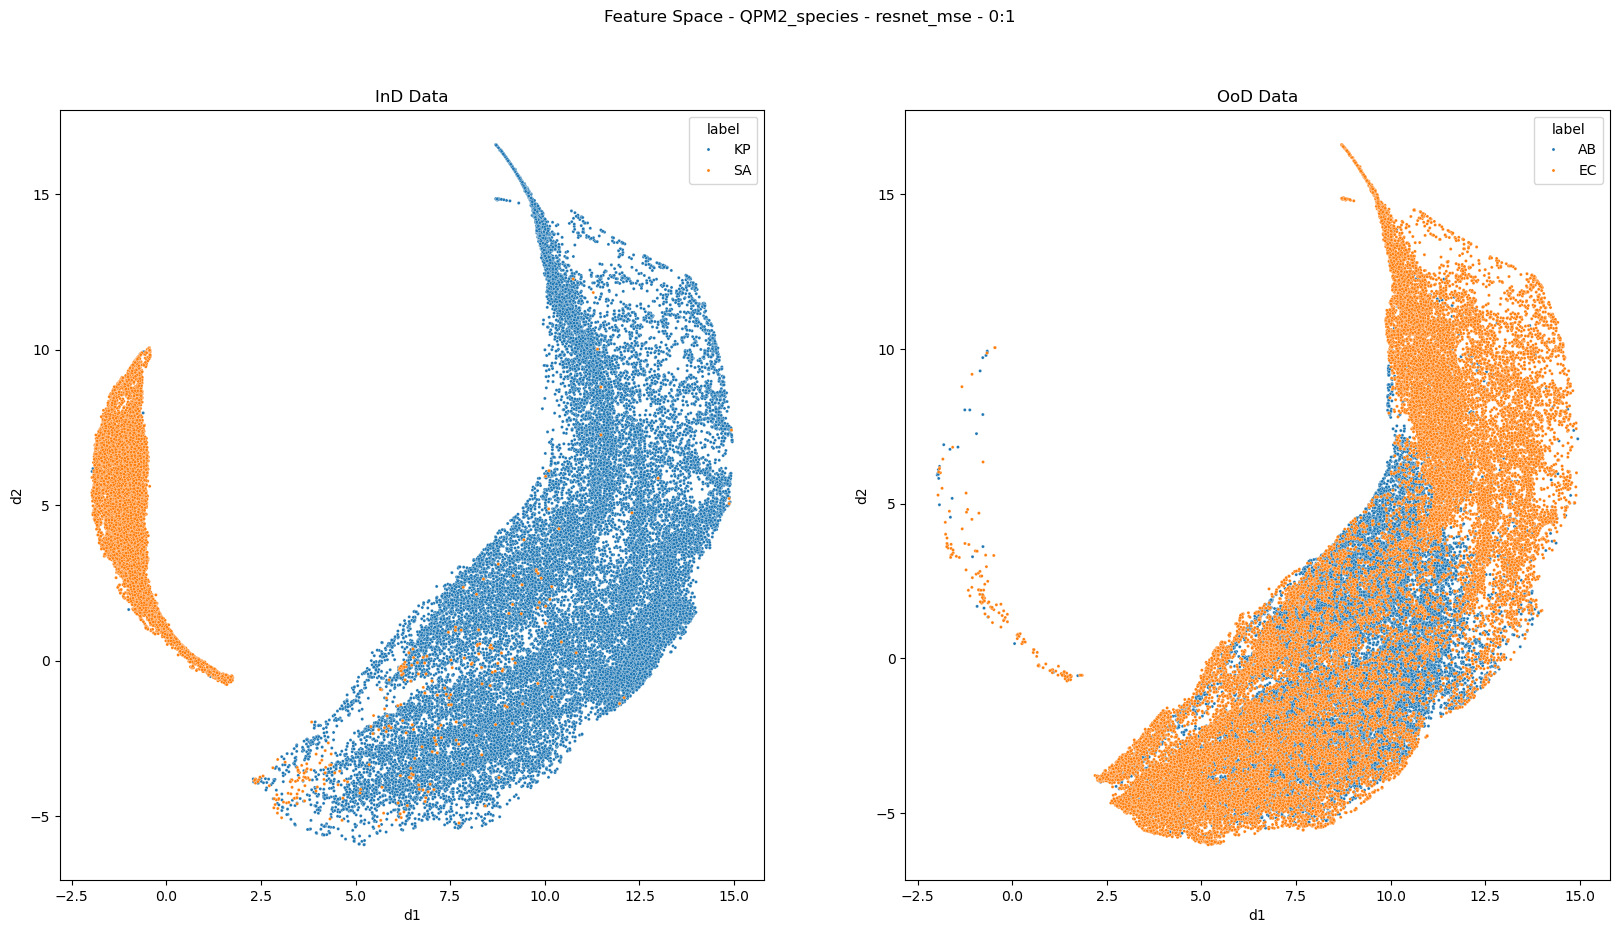

In [12]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

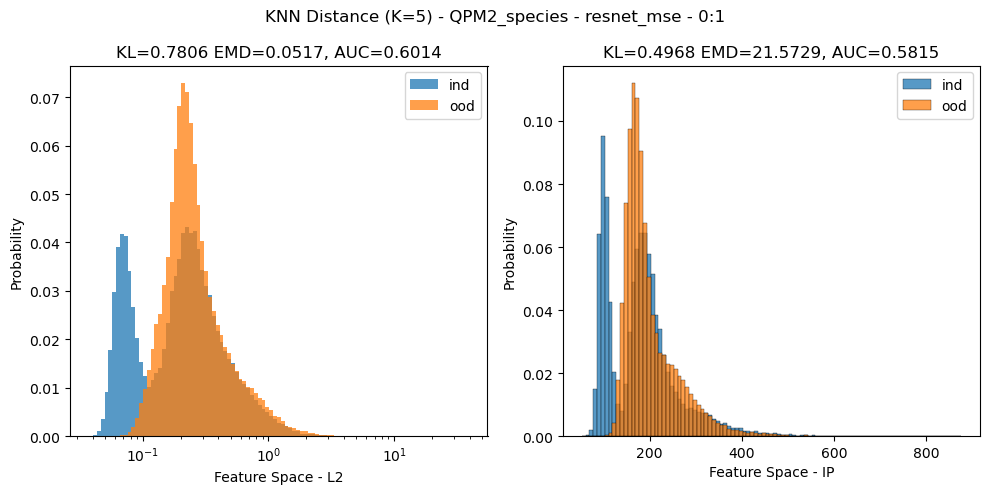

In [13]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
plt.tight_layout()
plt.show()

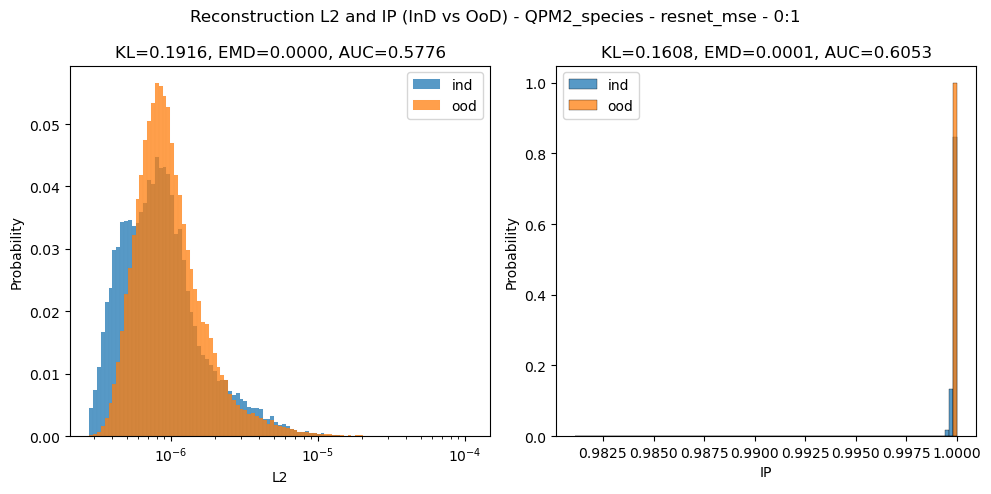

In [14]:
# plot reconstruction error of ind and ood data
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# training data
_val_inp, _val_rcn = flatten(val_inp), flatten(val_rcn)
_val_inp_unit, _val_rcn_unit = unit(_val_inp), unit(_val_rcn)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)

# ind test data
_ind_inp, _ind_rcn = flatten(ind_inp), flatten(ind_rcn)
_ind_inp_unit, _ind_rcn_unit = unit(_ind_inp), unit(_ind_rcn)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # ood test data
    _ood_inp, _ood_rcn = flatten(ood_inp), flatten(ood_rcn)
    _ood_inp_unit, _ood_rcn_unit = unit(_ood_inp), unit(_ood_rcn)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)